#### Imports

In [1]:
import torch
import numpy as np
from torch_geometric import nn as gnn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch import nn
from torch.utils.data import DataLoader
import math
from torch.utils.data import Dataset
import scanpy as sc
import scvelo as scv
import pandas as pd
from matplotlib import pyplot as plt
import model, util
from sklearn.model_selection import train_test_split
import wandb
import scvi
import umap
from sklearn.metrics import adjusted_rand_score
import warnings

In [2]:
torch.cuda.is_available()

True

#### Choose the dataset

In [19]:
st_path = "data/chicken_heart/Visium_D14_adata.h5ad"
scrna_path = "data/chicken_heart/RNA_D14_adata.h5ad"

In [17]:
st_path = "data/Mouse_brain/HybISS_adata.h5ad"
scrna_path = "data/Mouse_brain/RNA_adata.h5ad"

In [4]:
st_path = "data/Mouse_organogenesis/SeqFISH_AllEmbryos_adata.h5ad"
scrna_path = "data/Mouse_organogenesis/RNA_adata.h5ad"

#### Read the data

In [5]:
st = scv.read(st_path)
st

AnnData object with n_obs × n_vars = 52568 × 351
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_counts'
    var: 'GeneName'
    uns: 'celltype_mapped_refined_colors'
    obsm: 'X_umap', 'X_xy_loc'

In [5]:
scrna = scv.read(scrna_path)
scrna

AnnData object with n_obs × n_vars = 16861 × 29452
    obs: 'cell', 'barcode', 'sample', 'pool', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'sizeFactor', 'n_counts'
    var: 'GeneName', 'gene_count_corr'
    layers: 'spliced', 'unspliced'

In [6]:
# see more informations:
scrna.obs['celltype']

cell_36865                     Neural crest
cell_36866                        Allantois
cell_36867                        Erythroid
cell_36869     Forebrain/Midbrain/Hindbrain
cell_36870              Presomitic mesoderm
                           ...             
cell_139326                       Erythroid
cell_139327                       Erythroid
cell_139329             Presomitic mesoderm
cell_139330                       Erythroid
cell_139331    Forebrain/Midbrain/Hindbrain
Name: celltype, Length: 16861, dtype: category
Categories (24, object): ['Allantois', 'Anterior somitic tissues', 'Blood progenitors', 'Cardiomyocytes', ..., 'Sclerotome', 'Spinal cord', 'Splanchnic mesoderm', 'Surface ectoderm']

#### Integrate the data using SIRV

In [3]:
from SIRV.main import SIRV

In [3]:
# st_imputed = scv.read("data/Mouse_organogenesis/Integrated.h5ad")
st_imputed = scv.read("data/Mouse_organogenesis/Integrated-with-pca.h5ad")

In [4]:
# st_imputed = SIRV(st, scrna, 50, ['celltype']) # organogenesis

In [5]:
st_imputed

AnnData object with n_obs × n_vars = 52568 × 350
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_counts', 'celltype', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'GeneName'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap', 'X_xy_loc'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [6]:
scv.pp.normalize_per_cell(st_imputed, enforce=True)
# X is already normalized, and we need to undo that. We only want to normalize spliced/unspliced
st_imputed.X = st.to_df()[st_imputed.var_names]

Normalized count data: X, spliced, unspliced.


In [4]:
st_imputed.to_df() # X

Abcc4      Acp5    Acvr1    Acvr2a  Adora2b  \
embryo1_Pos0_cell10_z5     0.0  0.000000  0.00000  0.000000  0.00000   
embryo1_Pos0_cell100_z2    0.0  1.451855  0.00000  0.000000  0.00000   
embryo1_Pos0_cell100_z5    0.0  0.000000  0.50855  0.508550  0.50855   
embryo1_Pos0_cell101_z2    0.0  0.974916  0.00000  0.974916  0.00000   
embryo1_Pos0_cell101_z5    0.0  0.000000  0.00000  0.511589  0.00000   
...                        ...       ...      ...       ...      ...   
embryo3_Pos39_cell94_z2    0.0  0.000000  0.00000  0.000000  0.00000   
embryo3_Pos39_cell96_z5    0.0  0.000000  0.00000  0.000000  0.00000   
embryo3_Pos39_cell97_z2    0.0  0.000000  0.00000  0.000000  0.00000   
embryo3_Pos39_cell98_z5    0.0  0.538997  0.00000  0.000000  0.00000   
embryo3_Pos39_cell99_z2    0.0  0.000000  0.00000  0.000000  0.00000   

                              Afp     Ahnak   Akr1c19     Alas2   Aldh1a2  \
embryo1_Pos0_cell10_z5   0.000000  0.000000  0.000000  0.000000  1.134119   
embryo1_Pos0_cell100_z2  1.451855  0.000000  0.000000  1.451855  0.000000   
embryo1_Pos0_cell100_z5  0.000000  0.000000  0.508550  0.000000  0.508550   
embryo1_Pos0_cell101_z2  0.000000  0.974916  0.000000  0.974916  0.974916   
embryo1_Pos0_cell101_z5  0.000000  0.000000  0.000000  0.511589  0.000000   
...                           ...       ...       ...       ...       ...   
embryo3_Pos39_cell94_z2  0.000000  1.893889  0.000000  0.000000  0.000000   
embryo3_Pos39_cell96_z5  0.000000  0.585258  0.000000  0.000000  0.000000   
embryo3_Pos39_cell97_z2  0.735707  0.000000  0.000000  0.000000  0.000000   
embryo3_Pos39_cell98_z5  0.000000  0.000000  0.538997  0.000000  0.538997   
embryo3_Pos39_cell99_z2  0.000000  0.000000  0.000000  0.000000  0.000000   

                         ...  Wnt2b     Wnt3     Wnt3a     Wnt5a     Wnt5b  \
embryo1_Pos0_cell10_z5   ...    0.0  0.00000  0.000000  1.991334  0.000000   
embryo1_Pos0_cell100_z2  ...    0.0  0.00000  0.969078  0.000000  0.000000   
embryo1_Pos0_cell100_z5  ...    0.0  0.50855  0.000000  1.295142  0.508550   
embryo1_Pos0_cell101_z2  ...    0.0  0.00000  0.000000  0.000000  0.000000   
embryo1_Pos0_cell101_z5  ...    0.0  0.00000  0.511589  1.467804  0.511589   
...                      ...    ...      ...       ...       ...       ...   
embryo3_Pos39_cell94_z2  ...    0.0  0.00000  0.000000  0.000000  0.000000   
embryo3_Pos39_cell96_z5  ...    0.0  0.00000  0.000000  0.000000  0.000000   
embryo3_Pos39_cell97_z2  ...    0.0  0.00000  0.000000  0.000000  0.000000   
embryo3_Pos39_cell98_z5  ...    0.0  0.00000  0.000000  0.538997  0.000000   
embryo3_Pos39_cell99_z2  ...    0.0  0.00000  0.000000  1.087313  0.000000   

                            Wnt8a      Xist    Zfp444     Zfp57      Zic3  
embryo1_Pos0_cell10_z5   0.000000  1.134119  0.000000  1.134119  0.000000  
embryo1_Pos0_cell100_z2  0.969078  0.969078  0.000000  0.000000  0.969078  
embryo1_Pos0_cell100_z5  0.508550  0.508550  0.508550  0.508550  0.000000  
embryo1_Pos0_cell101_z2  0.000000  0.000000  0.000000  0.000000  0.000000  
embryo1_Pos0_cell101_z5  0.000000  0.511589  0.511589  1.099884  0.000000  
...                           ...       ...       ...       ...       ...  
embryo3_Pos39_cell94_z2  0.000000  0.000000  0.000000  0.000000  1.893889  
embryo3_Pos39_cell96_z5  0.000000  0.952009  0.000000  0.585258  0.000000  
embryo3_Pos39_cell97_z2  0.000000  1.449473  0.000000  0.735707  0.000000  
embryo3_Pos39_cell98_z5  0.000000  1.519826  0.000000  0.887303  1.349927  
embryo3_Pos39_cell99_z2  0.000000  0.000000  0.000000  1.595863  0.000000  

[52568 rows x 350 columns]

In [5]:
st_imputed.to_df("spliced")

Abcc4        Acp5     Acvr1    Acvr2a   Adora2b  \
embryo1_Pos0_cell10_z5   1.506156    5.978760  0.000000  0.000000  2.761718   
embryo1_Pos0_cell100_z2  0.000000  471.305635  0.000000  0.000000  1.870764   
embryo1_Pos0_cell100_z5  0.863332    2.702535  1.177655  3.362546  5.079361   
embryo1_Pos0_cell101_z2  0.000000  438.092765  0.000000  2.600134  0.000000   
embryo1_Pos0_cell101_z5  1.562520    4.582650  0.000000  5.389019  6.856044   
...                           ...         ...       ...       ...       ...   
embryo3_Pos39_cell94_z2  0.000000    1.974819  0.000000  5.593958  0.000000   
embryo3_Pos39_cell96_z5  0.000000    1.158184  0.000000  1.333816  3.183493   
embryo3_Pos39_cell97_z2  0.000000    1.237022  0.000000  1.094364  5.089191   
embryo3_Pos39_cell98_z5  0.761275    2.641851  0.000000  0.000000  1.930417   
embryo3_Pos39_cell99_z2  0.000000    0.000000  0.000000  0.000000  5.364351   

                               Afp     Ahnak   Akr1c19       Alas2    Aldh1a2  \
embryo1_Pos0_cell10_z5    2.375490  4.594969  0.000000    4.283704  17.385590   
embryo1_Pos0_cell100_z2  14.156360  2.133198  0.000000  794.808433   0.000000   
embryo1_Pos0_cell100_z5   8.123496  1.668757  0.811346    0.000000  13.402819   
embryo1_Pos0_cell101_z2  10.560898  0.000000  0.000000  626.222807   0.000000   
embryo1_Pos0_cell101_z5   1.236039  2.538010  0.000000    1.632516  26.321408   
...                            ...       ...       ...         ...        ...   
embryo3_Pos39_cell94_z2   8.175357  0.000000  0.000000    7.857257  74.538362   
embryo3_Pos39_cell96_z5   7.116952  0.000000  0.000000    0.000000   6.267519   
embryo3_Pos39_cell97_z2  11.158386  0.000000  0.000000    1.555310  10.622646   
embryo3_Pos39_cell98_z5   5.605800  0.000000  0.000000    4.744513  69.438958   
embryo3_Pos39_cell99_z2   8.788649  0.000000  0.000000    1.762778   8.482200   

                         ...  Wnt2b  Wnt3     Wnt3a       Wnt5a      Wnt5b  \
embryo1_Pos0_cell10_z5   ...    0.0   0.0  0.000000   78.330213  55.313157   
embryo1_Pos0_cell100_z2  ...    0.0   0.0  0.000000    0.000000   0.862077   
embryo1_Pos0_cell100_z5  ...    0.0   0.0  0.000000   99.807136  89.232559   
embryo1_Pos0_cell101_z2  ...    0.0   0.0  0.000000    0.000000   0.000000   
embryo1_Pos0_cell101_z5  ...    0.0   0.0  0.000000  101.880934  53.224006   
...                      ...    ...   ...       ...         ...        ...   
embryo3_Pos39_cell94_z2  ...    0.0   0.0  0.000000   17.113574  10.376953   
embryo3_Pos39_cell96_z5  ...    0.0   0.0  7.088811   52.261074  38.175480   
embryo3_Pos39_cell97_z2  ...    0.0   0.0  4.047675   37.132621  32.799060   
embryo3_Pos39_cell98_z5  ...    0.0   0.0  0.000000   26.414798  12.837993   
embryo3_Pos39_cell99_z2  ...    0.0   0.0  7.473034   41.304110  37.551645   

                         Wnt8a        Xist     Zfp444      Zfp57  Zic3  
embryo1_Pos0_cell10_z5     0.0  179.588092  24.229258   4.472249   0.0  
embryo1_Pos0_cell100_z2    0.0  239.438433  15.269631   0.000000   0.0  
embryo1_Pos0_cell100_z5    0.0  108.169054  41.125316  16.146209   0.0  
embryo1_Pos0_cell101_z2    0.0  312.783704  24.083458   0.000000   0.0  
embryo1_Pos0_cell101_z5    0.0   87.674895  29.356393   7.845339   0.0  
...                        ...         ...        ...        ...   ...  
embryo3_Pos39_cell94_z2    0.0  196.730045  41.855610   3.388628   0.0  
embryo3_Pos39_cell96_z5    0.0  143.067766  45.684057   5.616487   0.0  
embryo3_Pos39_cell97_z2    0.0  132.219029  44.557990   7.604345   0.0  
embryo3_Pos39_cell98_z5    0.0  141.836678  49.979839   5.179063   0.0  
embryo3_Pos39_cell99_z2    0.0  186.144870  42.547466   5.082612   0.0  

[52568 rows x 350 columns]

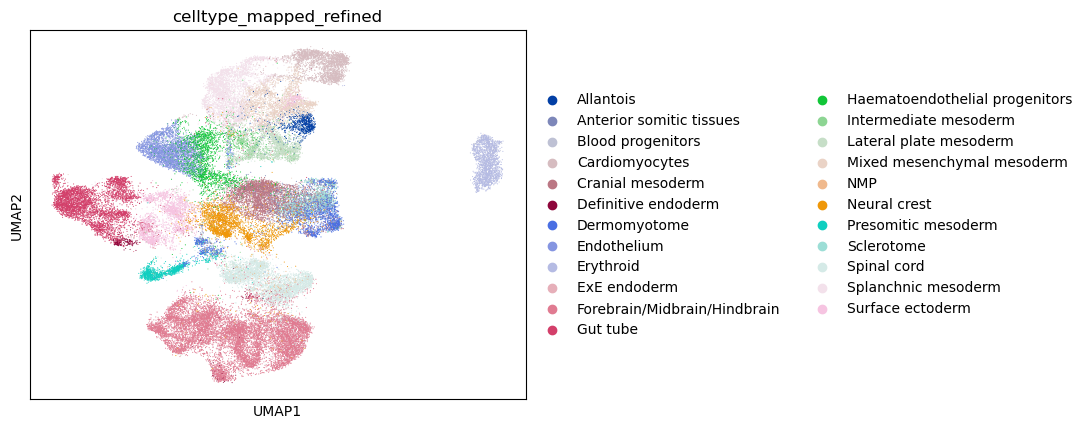

In [9]:
sc.pl.umap(st_imputed, color='celltype_mapped_refined')

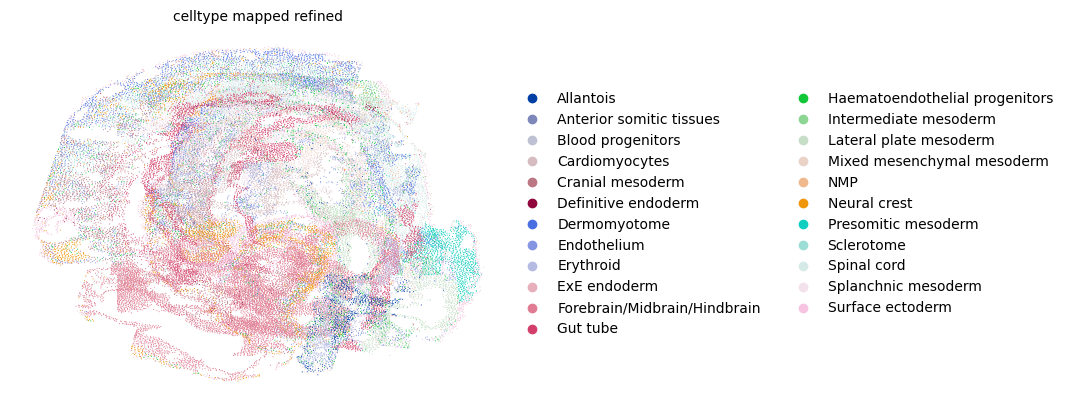

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(st_imputed, basis='X_xy_loc', color='celltype_mapped_refined', legend_loc='right margin')

#### Dimentionality reduction using PCA

In [11]:
sc.tl.pca(st_imputed)

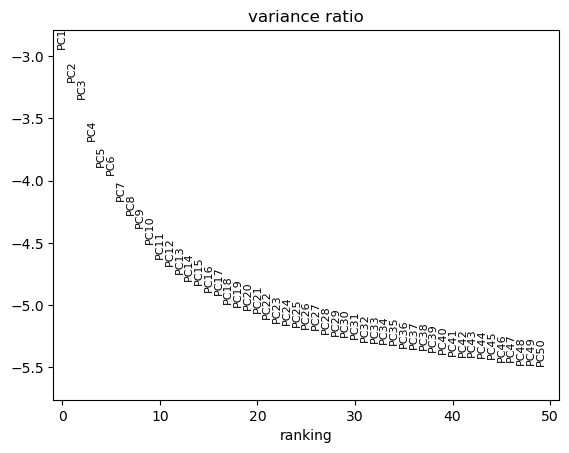

In [12]:
sc.pl.pca_variance_ratio(st_imputed, n_pcs=50, log=True)

In [13]:
sc.pp.neighbors(st_imputed, n_neighbors=30, n_pcs=30)

In [14]:
sc.tl.umap(st_imputed)
sc.tl.leiden(st_imputed)

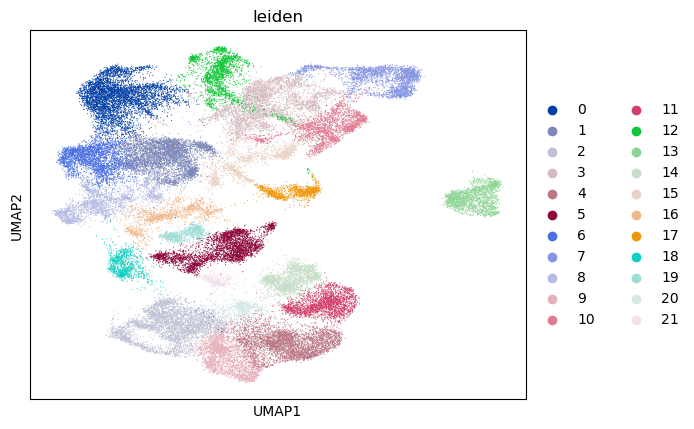

In [15]:
sc.pl.umap(st_imputed, color='leiden')

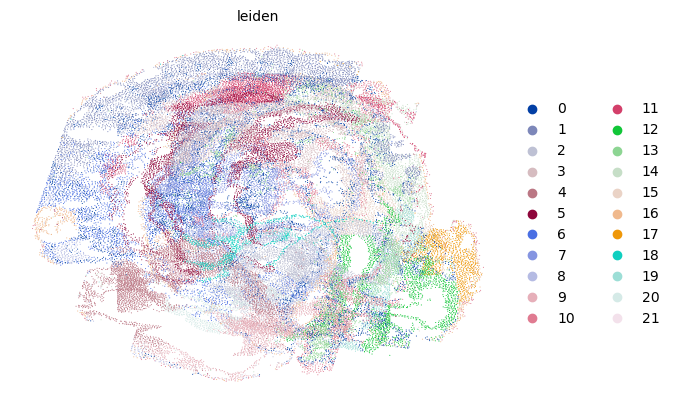

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(st_imputed, basis='X_xy_loc', color='leiden', legend_loc='right margin')

In [17]:
adjusted_rand_score(st_imputed.obs['leiden'], st_imputed.obs['celltype_mapped_refined'])
# ARI for PCA

0.5051740047474356

In [18]:
adjusted_rand_score(st_imputed.obs['leiden'], st_imputed.obs['celltype'])

0.47896626728905833

In [19]:
# st_imputed.write_h5ad("data/Mouse_organogenesis/Integrated-with-pca.h5ad")

#### Dimensionality reduction using SCVI VAE (using CPU is extremely slow)

In [23]:
scvi.model.SCVI.setup_anndata(st_imputed)

In [48]:
scvi_vae = scvi.model.SCVI(st_imputed, n_latent=30, n_layers=3)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scvi_vae.train(max_epochs=30, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:26<00:00,  2.88s/it, v_num=1, train_loss_step=168, train_loss_epoch=167]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:26<00:00,  2.89s/it, v_num=1, train_loss_step=168, train_loss_epoch=167]


In [49]:
st_imputed.obsm['X_scvi'] = scvi_vae.get_latent_representation()

In [50]:
# st_imputed.write_h5ad("scvi-Integrated.h5ad")

In [51]:
sc.pp.neighbors(st_imputed, use_rep='X_scvi', n_neighbors=30, n_pcs=30)
# either X_scvi or X_pca
sc.tl.umap(st_imputed)
sc.tl.leiden(st_imputed)

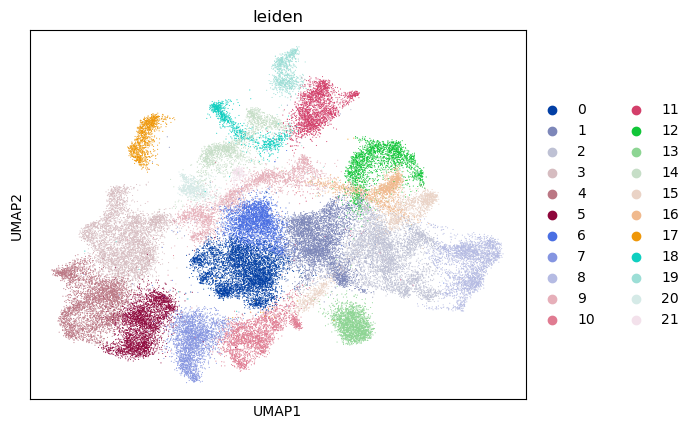

In [35]:
sc.pl.umap(st_imputed, color='leiden')

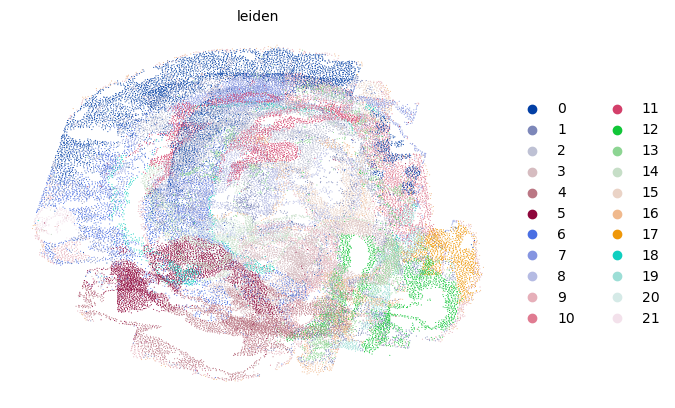

In [34]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    scv.pl.scatter(st_imputed, basis='X_xy_loc', color='leiden', legend_loc='right margin')

In [54]:
adjusted_rand_score(st_imputed.obs['leiden'], st_imputed.obs['celltype_mapped_refined'])

0.49400432599524036

In [55]:
adjusted_rand_score(st_imputed.obs['leiden'], st_imputed.obs['celltype'])

0.4713268052985184

#### Numerical gradient estimation

In [4]:
from util import discretize_coord, numeric_gradient, SpatialDataset, SpatialGradientDataset

In [5]:
# check the format of spatial data
xy = np.array(st_imputed.obsm['X_xy_loc'])

In [6]:
print(np.min(xy, axis=0), np.max(xy, axis=0))

[-3.53302647 -4.12620251] [3.06208105 4.18471691]


In [7]:
xy_new = np.array(discretize_coord(xy, cell_size=0.025))
# cell_size defines the resolution
st_imputed.obsm['X_xy_loc_disc'] = xy_new
Dx, Dy, S, S_count, Dx_cell, Dy_cell = numeric_gradient(st_imputed, target='spliced')

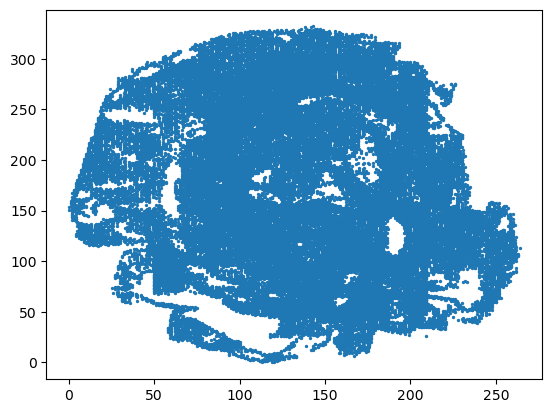

In [12]:
plt.scatter(xy_new[:, 0], xy_new[:, 1], s = 2)
plt.show()

In [13]:
st_imputed

AnnData object with n_obs × n_vars = 52568 × 350
    obs: 'uniqueID', 'embryo', 'pos', 'z', 'x_global', 'y_global', 'x_global_affine', 'y_global_affine', 'embryo_pos', 'embryo_pos_z', 'Area', 'UMAP1', 'UMAP2', 'celltype_mapped_refined', 'n_counts', 'celltype', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'GeneName'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_mapped_refined_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap', 'X_xy_loc', 'X_xy_loc_disc'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

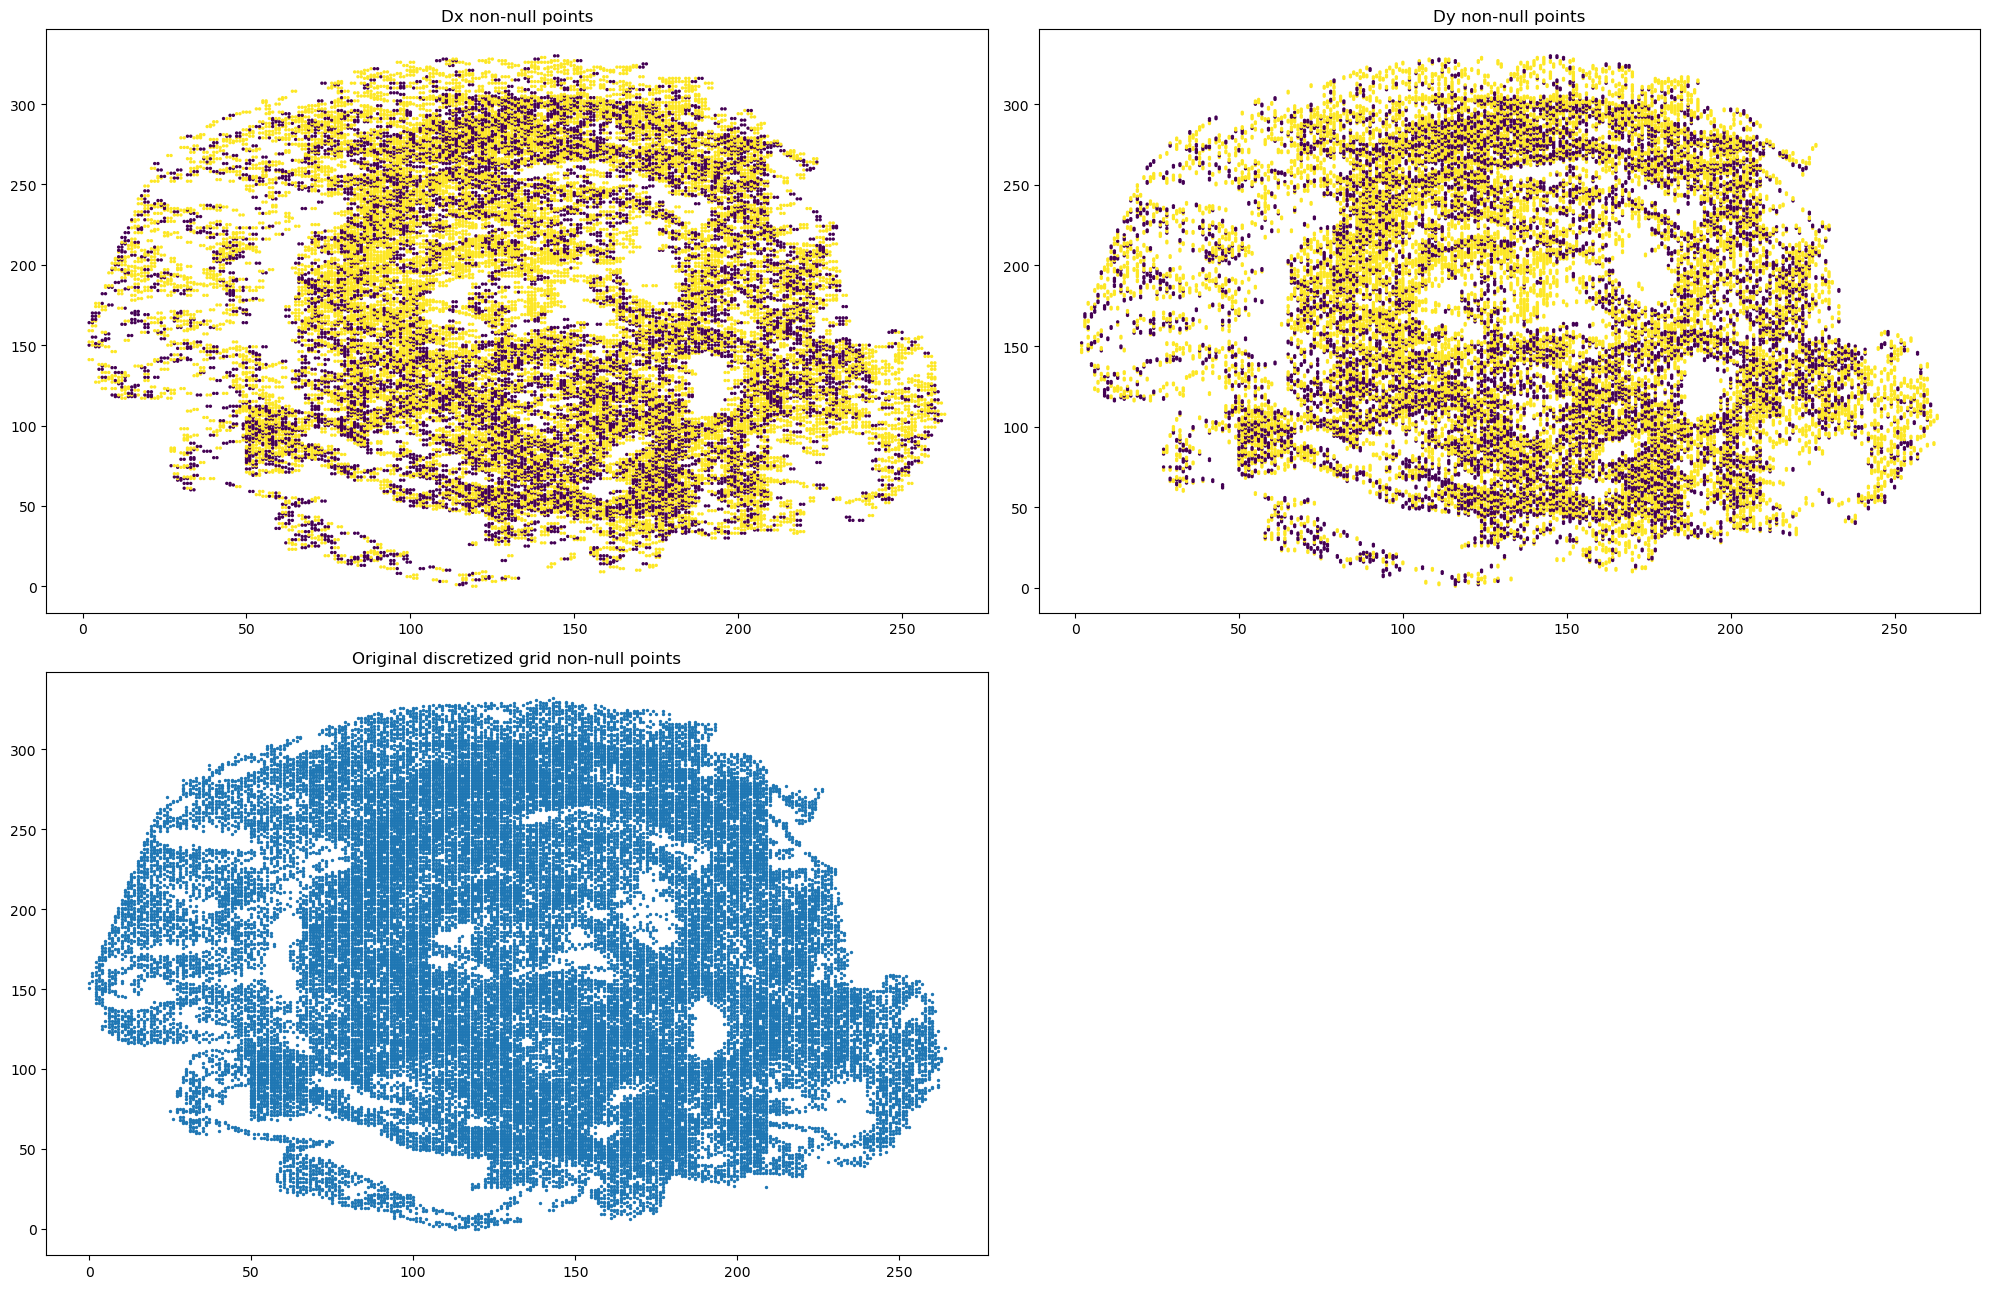

In [14]:
# a plot to show the discretization result. For best visualization, the cell_size is large.

fig, axs = plt.subplots(figsize=(20, 13), nrows = 2, ncols = 2)

xx, yy = np.where(~np.isnan(Dx[:, :, 0]))
axs[0][0].scatter(xx, yy, s=2, c=(Dx[xx, yy, 0] < 0.01))
axs[0][0].title.set_text('Dx non-null points')
xx, yy = np.where(~np.isnan(Dy[:, :, 0]))
axs[0][1].scatter(xx, yy, s=2, c=(Dy[xx, yy, 0] < 0.01))
axs[0][1].title.set_text('Dy non-null points')
xx, yy = np.where(~np.isnan(S[:, :, 0]))
axs[1][0].scatter(xx, yy, s=2)
axs[1][0].title.set_text('Original discretized grid non-null points')
fig.delaxes(axs[1, 1])
plt.tight_layout()
plt.show()

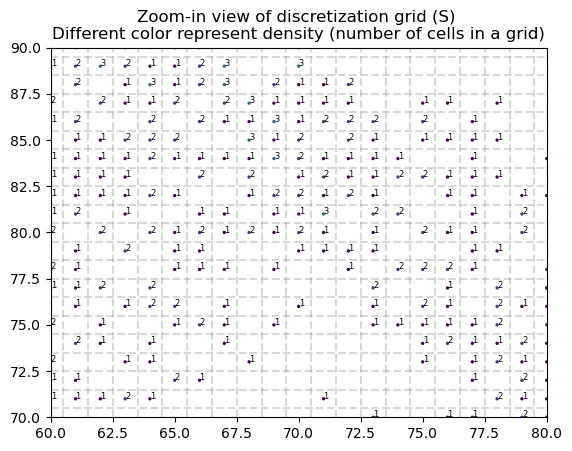

7.0


In [15]:
# make a zoom-in plot to demonstrate how the discretization is done.
xx, yy = np.where(~np.isnan(S[:, :, 0]))
plt.scatter(xx, yy, s=2, c=S_count[xx, yy])

for y in np.linspace(70.5, 89.5, 20):
    plt.axhline(y, linestyle='--', alpha=0.3, color='grey')
for x in np.linspace(60.5, 79.5, 20):
    plt.axvline(x, linestyle='--', alpha=0.3, color='grey')

for ix, iy in zip(xx, yy):
    if ix not in np.arange(60, 80) or iy not in np.arange(70, 90):
        continue
    plt.annotate(int(S_count[ix, iy]), (ix, iy), fontsize=6)

plt.xlim(60, 80)
plt.ylim(70, 90)
plt.title('Zoom-in view of discretization grid (S) \nDifferent color represent density (number of cells in a grid)')
plt.show()
print(np.max(S_count))

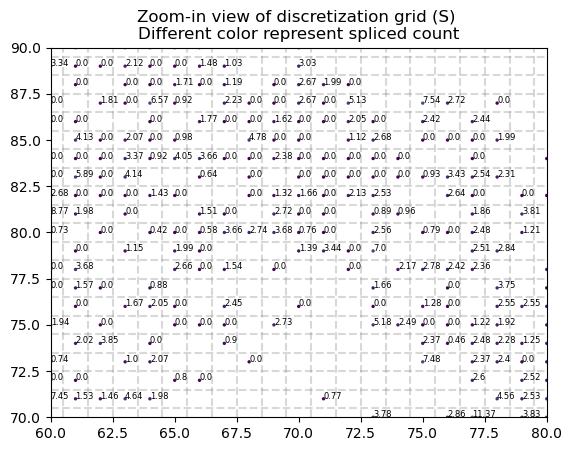

In [95]:
xx, yy = np.where(~np.isnan(S[:, :, 0]))
plt.scatter(xx, yy, s=2, c=S[xx, yy, 0])

for y in np.linspace(70.5, 89.5, 20):
    plt.axhline(y, linestyle='--', alpha=0.3, color='grey')
for x in np.linspace(60.5, 79.5, 20):
    plt.axvline(x, linestyle='--', alpha=0.3, color='grey')

for ix, iy in zip(xx, yy):
    if ix not in np.arange(60, 80) or iy not in np.arange(70, 90):
        continue
    plt.annotate(round(S[ix, iy, 0], 2), (ix, iy), fontsize=6)

plt.xlim(60, 80)
plt.ylim(70, 90)
plt.title('Zoom-in view of discretization grid (S) \nDifferent color represent spliced count')
plt.show()

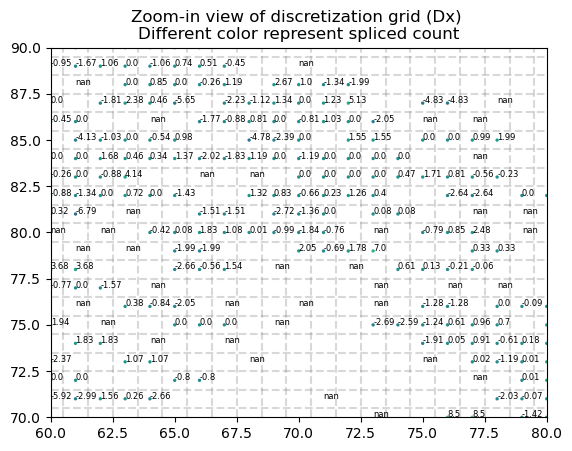

In [96]:
xx, yy = np.where(~np.isnan(S[:, :, 0]))
plt.scatter(xx, yy, s=2, c=Dx[xx, yy, 0])

for y in np.linspace(70.5, 89.5, 20):
    plt.axhline(y, linestyle='--', alpha=0.3, color='grey')
for x in np.linspace(60.5, 79.5, 20):
    plt.axvline(x, linestyle='--', alpha=0.3, color='grey')

for ix, iy in zip(xx, yy):
    if ix not in np.arange(60, 80) or iy not in np.arange(70, 90):
        continue
    plt.annotate(round(Dx[ix, iy, 0], 2), (ix, iy), fontsize=6)

plt.xlim(60, 80)
plt.ylim(70, 90)
plt.title('Zoom-in view of discretization grid (Dx) \nDifferent color represent spliced count')
plt.show()

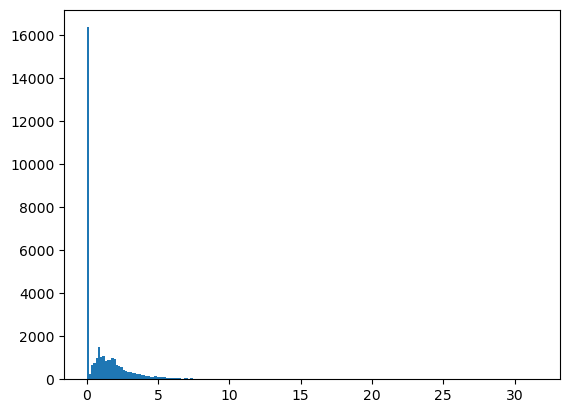

In [97]:
plt.hist(S[xx, yy, 0], bins=200)
plt.show()

# zero-inflated

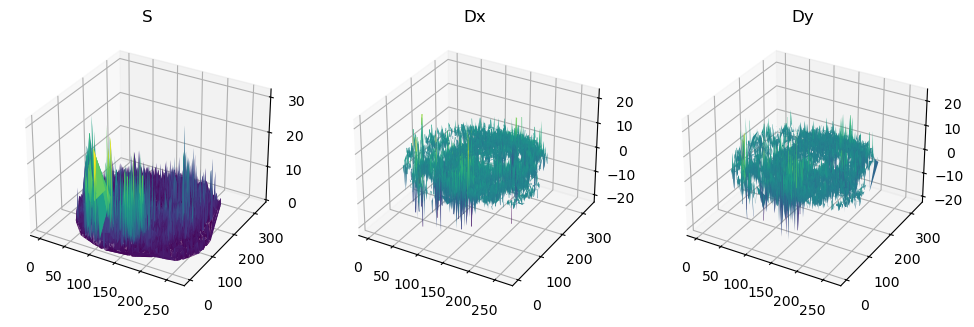

In [10]:
# plot the distribution of S, Dx, Dy
from mpl_toolkits.mplot3d.axes3d import Axes3D

gene = 0

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(131, projection='3d')
ax.plot_trisurf(xx, yy, S[xx, yy, gene], cmap='viridis')
ax.set_title('S')

ax = fig.add_subplot(132, projection='3d')
ax.plot_trisurf(xx, yy, Dx[xx, yy, gene], cmap='viridis')
ax.set_title('Dx')

ax = fig.add_subplot(133, projection='3d')
ax.plot_trisurf(xx, yy, Dy[xx, yy, gene], cmap='viridis')
ax.set_title('Dy')
plt.show()

#### Models for interpolation

In [8]:
from model import MLP, GAT, KCN, ZI_lp_loss, ZeroInflatedGAT
from sklearn.preprocessing import StandardScaler

In [9]:
# get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
# convert to torch tensors
Dx_cell = torch.tensor(Dx_cell)
Dy_cell = torch.tensor(Dy_cell)
xy = torch.tensor(xy)
latent = torch.tensor(st_imputed.obsm['X_pca'])

xy.is_cuda

False

In [11]:
xgrad_notNaN = torch.where(~torch.isnan(Dx_cell[:, 0]))[0]

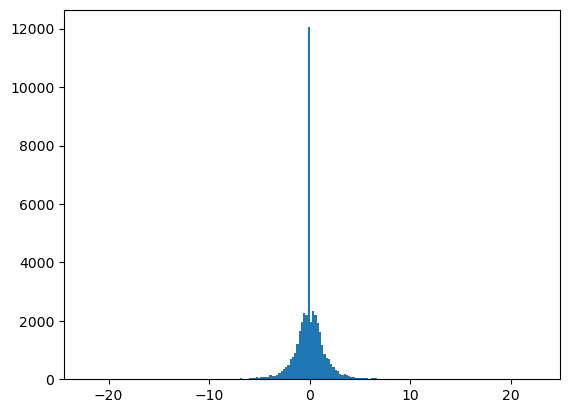

(tensor(26690), 43570)

In [12]:
plt.hist(Dx_cell[xgrad_notNaN][:, 0], bins=200)
plt.show()
# in fact no data is 0; most are small values
sum(Dx_cell[xgrad_notNaN][:, 0] < 0.001), len(Dx_cell[xgrad_notNaN][:, 0])

In [13]:
# seems the data without scaling is good enough (scvelo preprocessing already did this)
scaler = StandardScaler()
Dx_cell = torch.tensor(scaler.fit_transform(Dx_cell))

scaler = StandardScaler()
Dy_cell = torch.tensor(scaler.fit_transform(Dy_cell))

scaler = StandardScaler()
latent = torch.tensor(scaler.fit_transform(latent))

In [14]:
edge_index = gnn.knn_graph(torch.tensor(xy), k=5, flow='source_to_target')
edge_index = torch.cat([edge_index, edge_index.flip(dims=[0])], dim=1).unique(dim=1)
edge_index.shape

torch.Size([2, 305112])

In [15]:
# how about using RadiusNeighboring?
# edge_index = gnn.radius_graph(torch.tensor(xy), r=0.035, flow='source_to_target')
# edge_index = torch.cat([edge_index, edge_index.flip(dims=[0])], dim=1).unique(dim=1)
# edge_index.shape

In [16]:
N, latent_dim = latent.shape
N, latent_dim

(52568, 50)

In [17]:
gene_dim = st_imputed.to_df().to_numpy().shape[1]
gene_dim

350

##### MLP (bad)

In [13]:
xmlp = MLP(latent_dim + 2, hidden_dims=[64, 64], out_channels=gene_dim).double().to(device)

In [13]:
# get the non-null data
xgrad_notNaN = torch.where(~torch.isnan(Dx_cell[:, 0]))[0]
x_spatial_grad_df = SpatialGradientDataset(xy[xgrad_notNaN], latent[xgrad_notNaN], Dx_cell[xgrad_notNaN])
x_spatial_grad_loader = torch.utils.data.DataLoader(x_spatial_grad_df, batch_size=256, shuffle=True)

In [15]:
len(x_spatial_grad_df)

52539

In [16]:
losses = xmlp.train_model(x_spatial_grad_loader, device, lr=1e-2, epoch=500)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:56<00:00,  2.11it/s]


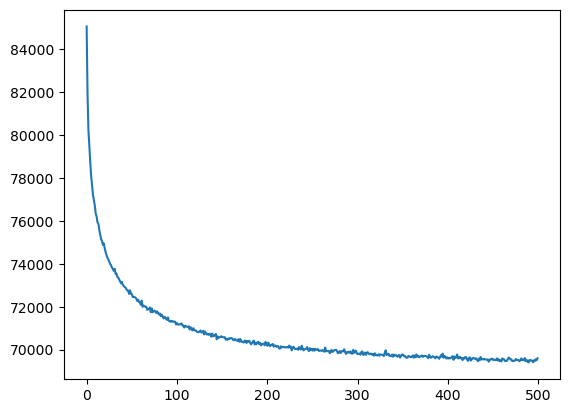

In [17]:
plt.plot(losses)
plt.show()

In [26]:
# see the predictions of mlp model
xmlp.eval()
Dx_cell_pred = xmlp.cpu()(torch.cat((xy.double(), latent.double()), dim=1))
Dx_cell_pred

torch.where(Dx_cell_pred != 0)

(tensor([    1,     1,     1,  ..., 52566, 52566, 52567]),
 tensor([ 21,  53,  75,  ..., 245, 255, 255]))

In [21]:
Dx_pred = np.nan * np.empty_like(Dx)
count = np.zeros_like(Dx[:, :, 0])

for (ix, iy), iDx in zip(xy_new, np.array(Dx_cell_pred.detach())):
    count[ix][iy] += 1
    if count[ix][iy] == 1:
        Dx_pred[ix][iy] = iDx
    else:
        Dx_pred[ix][iy] += (iDx - Dx_pred[ix][iy]) / count[ix][iy]

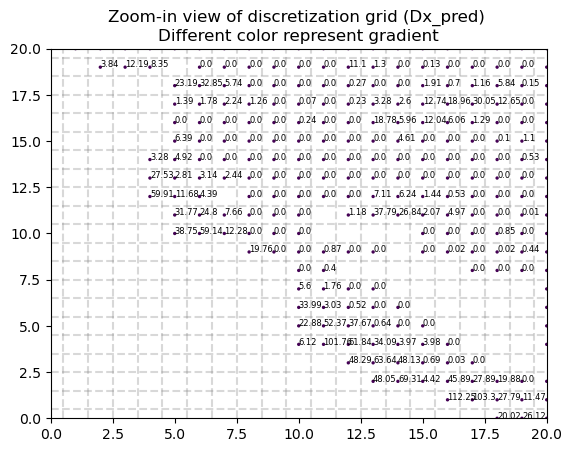

In [32]:
xx, yy = np.where(~np.isnan(S[:, :, 0]))
plt.scatter(xx, yy, s=2, c=Dx_pred[xx, yy, 0])

for y in np.linspace(0.5, 19.5, 20):
    plt.axhline(y, linestyle='--', alpha=0.3, color='grey')
for x in np.linspace(0.5, 19.5, 20):
    plt.axvline(x, linestyle='--', alpha=0.3, color='grey')

for ix, iy in zip(xx, yy):
    if ix >= 20 or iy >= 20:
        continue
    plt.annotate(round(Dx_pred[ix, iy, 53], 2), (ix, iy), fontsize=6)

plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title('Zoom-in view of discretization grid (Dx_pred) \nDifferent color represent gradient')
plt.show()

##### GAT

In [45]:
xgat = GAT(latent_dim + 2, hidden_dims=[32, 32], out_channels=1, dropout=0.5, p=2.0, gamma=1.0).double().to(device)

In [46]:
losses = xgat.train_model(xy, latent, Dx_cell[:, 0][:, None], edge_index, device, lr=3e-2, epoch=2000)
# losses = xgat.train_model(xy, latent, Dx_cell, edge_index, device, lr=3e-2, epoch=5000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:54<00:00, 36.73it/s]


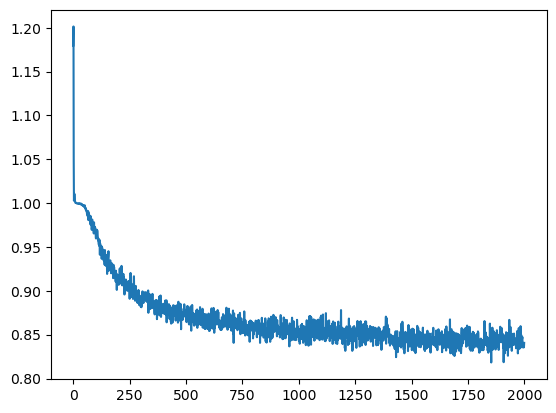

In [47]:
plt.plot(losses)
plt.show()

In [48]:
xgat.eval()
Dx_cell_pred = xgat.cpu()(torch.cat((xy.double(), latent.double()), dim=1), edge_index)

In [49]:
Dx_pred = np.nan * np.empty_like(Dx)
count = np.zeros_like(Dx[:, :, 0])

for (ix, iy), iDx in zip(xy_new, np.array(Dx_cell_pred.detach())):
    count[ix][iy] += 1
    if count[ix][iy] == 1:
        Dx_pred[ix][iy] = iDx
    else:
        Dx_pred[ix][iy] += (iDx - Dx_pred[ix][iy]) / count[ix][iy]

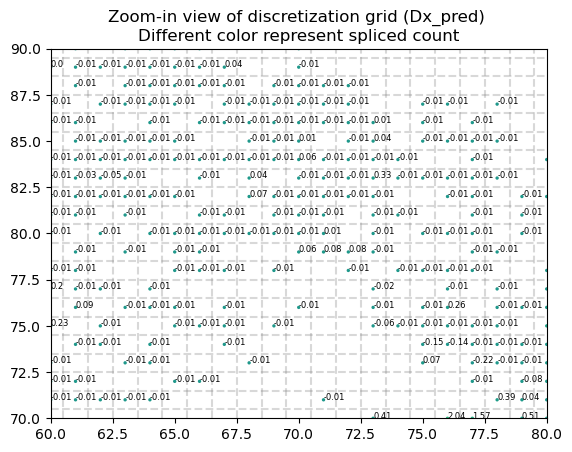

In [50]:
xx, yy = np.where(~np.isnan(S[:, :, 0]))
plt.scatter(xx, yy, s=2, c=Dx_pred[xx, yy, 0])

for y in np.linspace(70.5, 89.5, 20):
    plt.axhline(y, linestyle='--', alpha=0.3, color='grey')
for x in np.linspace(60.5, 79.5, 20):
    plt.axvline(x, linestyle='--', alpha=0.3, color='grey')

for ix, iy in zip(xx, yy):
    if ix not in np.arange(60, 80) or iy not in np.arange(70, 90):
        continue
    plt.annotate(round(Dx_pred[ix, iy, 0], 2), (ix, iy), fontsize=6)

plt.xlim(60, 80)
plt.ylim(70, 90)
plt.title('Zoom-in view of discretization grid (Dx_pred) \nDifferent color represent spliced count')
plt.show()

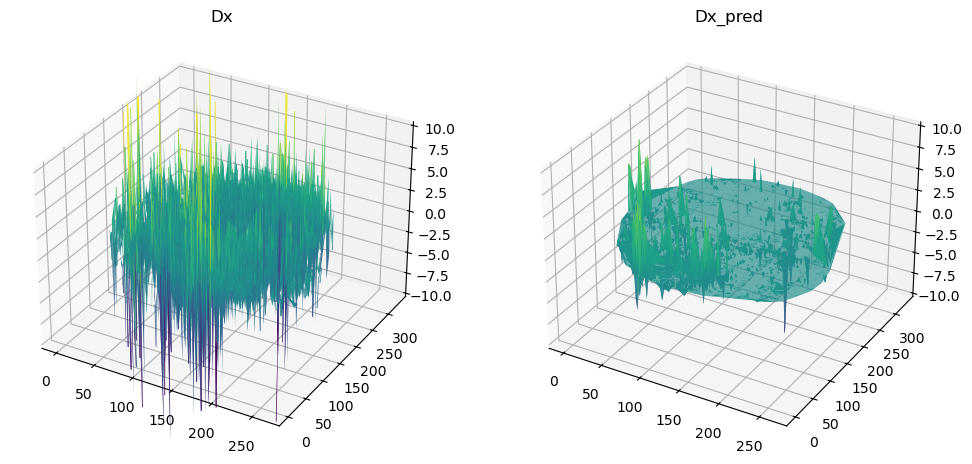

In [51]:
# plot the distribution of S, Dx, Dy
from mpl_toolkits.mplot3d.axes3d import Axes3D

gene = 0

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_trisurf(xx, yy, Dx[xx, yy, gene], cmap='viridis', vmin=-10, vmax=10)
ax1.set_zlim(-10, 10)
ax1.set_title('Dx')

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_trisurf(xx, yy, Dx_pred[xx, yy, gene], cmap='viridis', vmin=-10, vmax=10)
ax2.set_zlim(-10, 10)
ax2.set_title('Dx_pred')

plt.show()

In [52]:
from scipy.stats import pearsonr, spearmanr
pearsonr(Dx_cell_pred[xgrad_notNaN][:, 0].squeeze().detach().numpy(), Dx_cell[xgrad_notNaN][:, 0])

PearsonRResult(statistic=0.4768641041944055, pvalue=0.0)

In [53]:
spearmanr(Dx_cell_pred[xgrad_notNaN][:, 0].squeeze().detach().numpy(), Dx_cell[xgrad_notNaN][:, 0])

SignificanceResult(statistic=0.2078818859598405, pvalue=0.0)

##### KCN

In [17]:
grad_notNaN = torch.where(~torch.isnan(Dx_cell[:, 0]))[0]
xkcn = KCN(xy[grad_notNaN].double(), latent[grad_notNaN].double(), Dx_cell[grad_notNaN].double(), 
           n_neighbors=5, hidden_size=[32, 32], device=device).double().to(device)

In [18]:
losses = xkcn.train_model(epoch=200, lr=3e-2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:59<00:00,  1.20s/it]


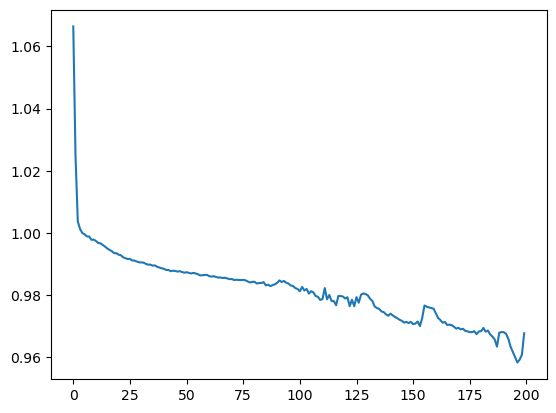

In [19]:
plt.plot(losses)
plt.show()

In [20]:
xkcn.eval()
Dx_cell_pred = xkcn(xy.double(), latent.double())

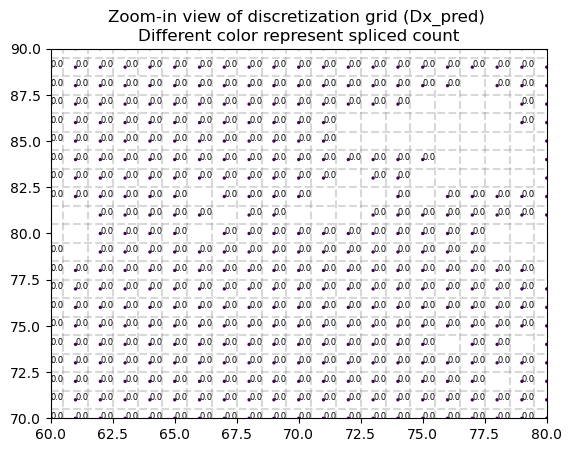

In [21]:
Dx_cell_pred = Dx_cell_pred.cpu()
Dx_pred = np.nan * np.empty_like(Dx)
count = np.zeros_like(Dx[:, :, 0])

for (ix, iy), iDx in zip(xy_new, np.array(Dx_cell_pred.detach())):
    count[ix][iy] += 1
    if count[ix][iy] == 1:
        Dx_pred[ix][iy] = iDx
    else:
        Dx_pred[ix][iy] += (iDx - Dx_pred[ix][iy]) / count[ix][iy]
        
xx, yy = np.where(~np.isnan(S[:, :, 0]))
plt.scatter(xx, yy, s=2, c=Dx_pred[xx, yy, 0])

for y in np.linspace(70.5, 89.5, 20):
    plt.axhline(y, linestyle='--', alpha=0.3, color='grey')
for x in np.linspace(60.5, 79.5, 20):
    plt.axvline(x, linestyle='--', alpha=0.3, color='grey')

for ix, iy in zip(xx, yy):
    if ix not in np.arange(60, 80) or iy not in np.arange(70, 90):
        continue
    plt.annotate(round(Dx_pred[ix, iy, 0], 2), (ix, iy), fontsize=6)

plt.xlim(60, 80)
plt.ylim(70, 90)
plt.title('Zoom-in view of discretization grid (Dx_pred) \nDifferent color represent spliced count')
plt.show()

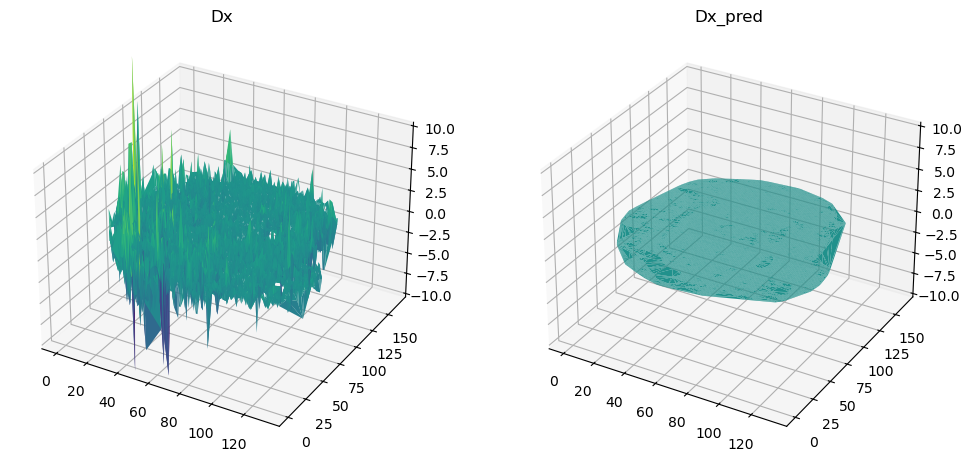

In [22]:
# plot the distribution of S, Dx, Dy
from mpl_toolkits.mplot3d.axes3d import Axes3D

gene = 0

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_trisurf(xx, yy, Dx[xx, yy, gene], cmap='viridis', vmin=-10, vmax=10)
ax1.set_zlim(-10, 10)
ax1.set_title('Dx')

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_trisurf(xx, yy, Dx_pred[xx, yy, gene], cmap='viridis', vmin=-10, vmax=10)
ax2.set_zlim(-10, 10)
ax2.set_title('Dx_pred')

plt.show()

In [23]:
from scipy.stats import pearsonr, spearmanr
pearsonr(Dx_cell_pred[xgrad_notNaN][:, 0].squeeze().detach().numpy(), Dx_cell[xgrad_notNaN][:, 0])

PearsonRResult(statistic=nan, pvalue=nan)

In [24]:
spearmanr(Dx_cell_pred[xgrad_notNaN][:, 0].squeeze().detach().numpy(), Dx_cell[xgrad_notNaN][:, 0])

SignificanceResult(statistic=nan, pvalue=nan)

##### Zero-inflated GAT

In [41]:
xZIgat = ZeroInflatedGAT(latent_dim + 2, hidden_dims=[64, 64], out_channels=1, dropout=0.3).double().to(device)

In [42]:
c_losses, r_losses = xZIgat.train_model(xy, latent, Dy_cell[:, 0][:, None], edge_index, device, alpha=0.2, lr=3e-3, epoch=2000)
# losses = xZIgat.train_model(xy, latent, Dy_cell, edge_index, device, lr=3e-2, epoch=5000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:04<00:00, 10.83it/s]


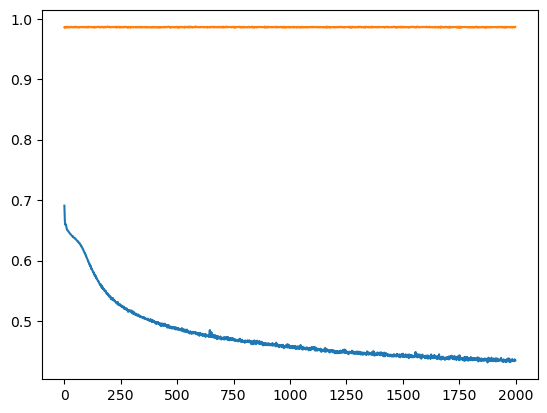

In [43]:
plt.plot(c_losses)
plt.plot(r_losses)
plt.show()

In [44]:
xZIgat.eval()
with torch.no_grad():
    Dx_cell_zero, Dx_cell_res = xZIgat.cpu()(torch.cat((xy.double(), latent.double()), dim=1), edge_index)
    Dx_cell_pred = xZIgat.cpu().predict(torch.cat((xy.double(), latent.double()), dim=1), edge_index)

Dx_pred = np.nan * np.empty_like(Dx)
count = np.zeros_like(Dx[:, :, 0])

for (ix, iy), iDx in zip(xy_new, np.array(Dx_cell_pred.detach())):
    count[ix][iy] += 1
    if count[ix][iy] == 1:
        Dx_pred[ix][iy] = iDx
    else:
        Dx_pred[ix][iy] += (iDx - Dx_pred[ix][iy]) / count[ix][iy]

from sklearn.metrics import accuracy_score
accuracy_score(1 * (Dx_cell[:, 0] < 0.01), 1 * (Dx_cell_zero[:, 0] > 0.5))

0.5308742961497489

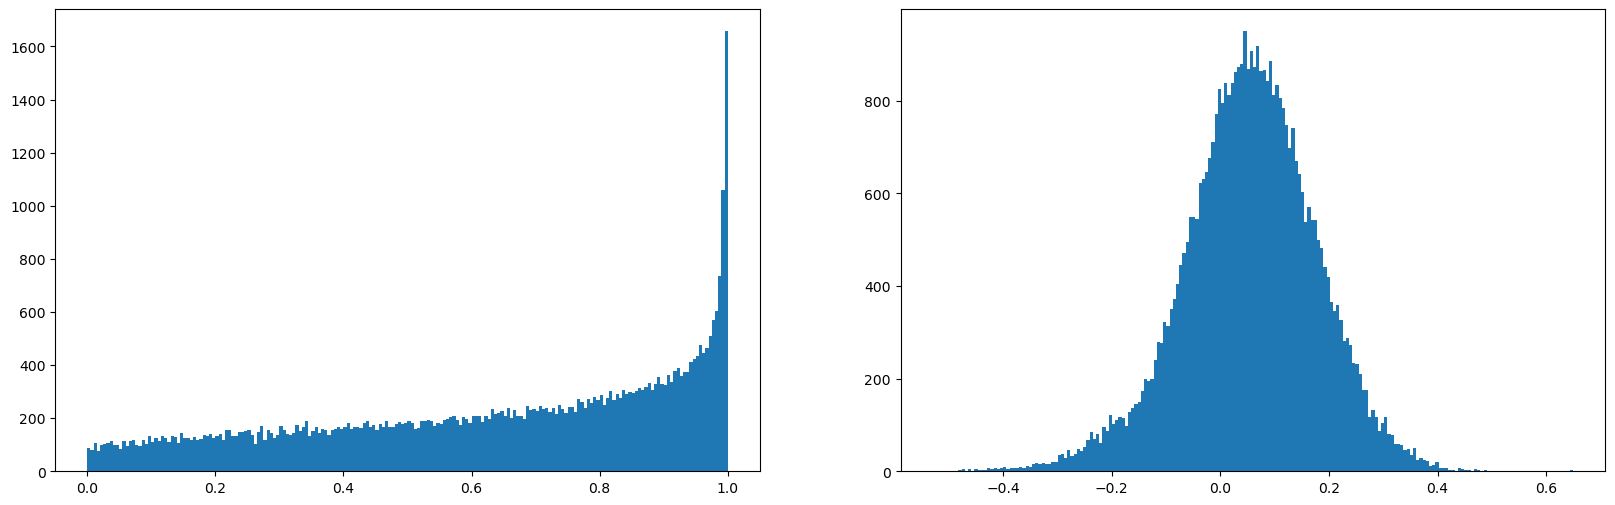

(tensor(33845), 43570)

In [45]:
fig, axs = plt.subplots(figsize=(20,6), ncols = 2)
axs[0].hist(Dx_cell_zero[xgrad_notNaN][:, 0], bins=200)
axs[1].hist(Dx_cell_res[xgrad_notNaN][:, 0], bins=200)
plt.show()
# in fact no data is 0; most are small values
sum(Dx_cell_pred[xgrad_notNaN][:, 0] < 0.001), len(Dx_cell_pred[xgrad_notNaN][:, 0])

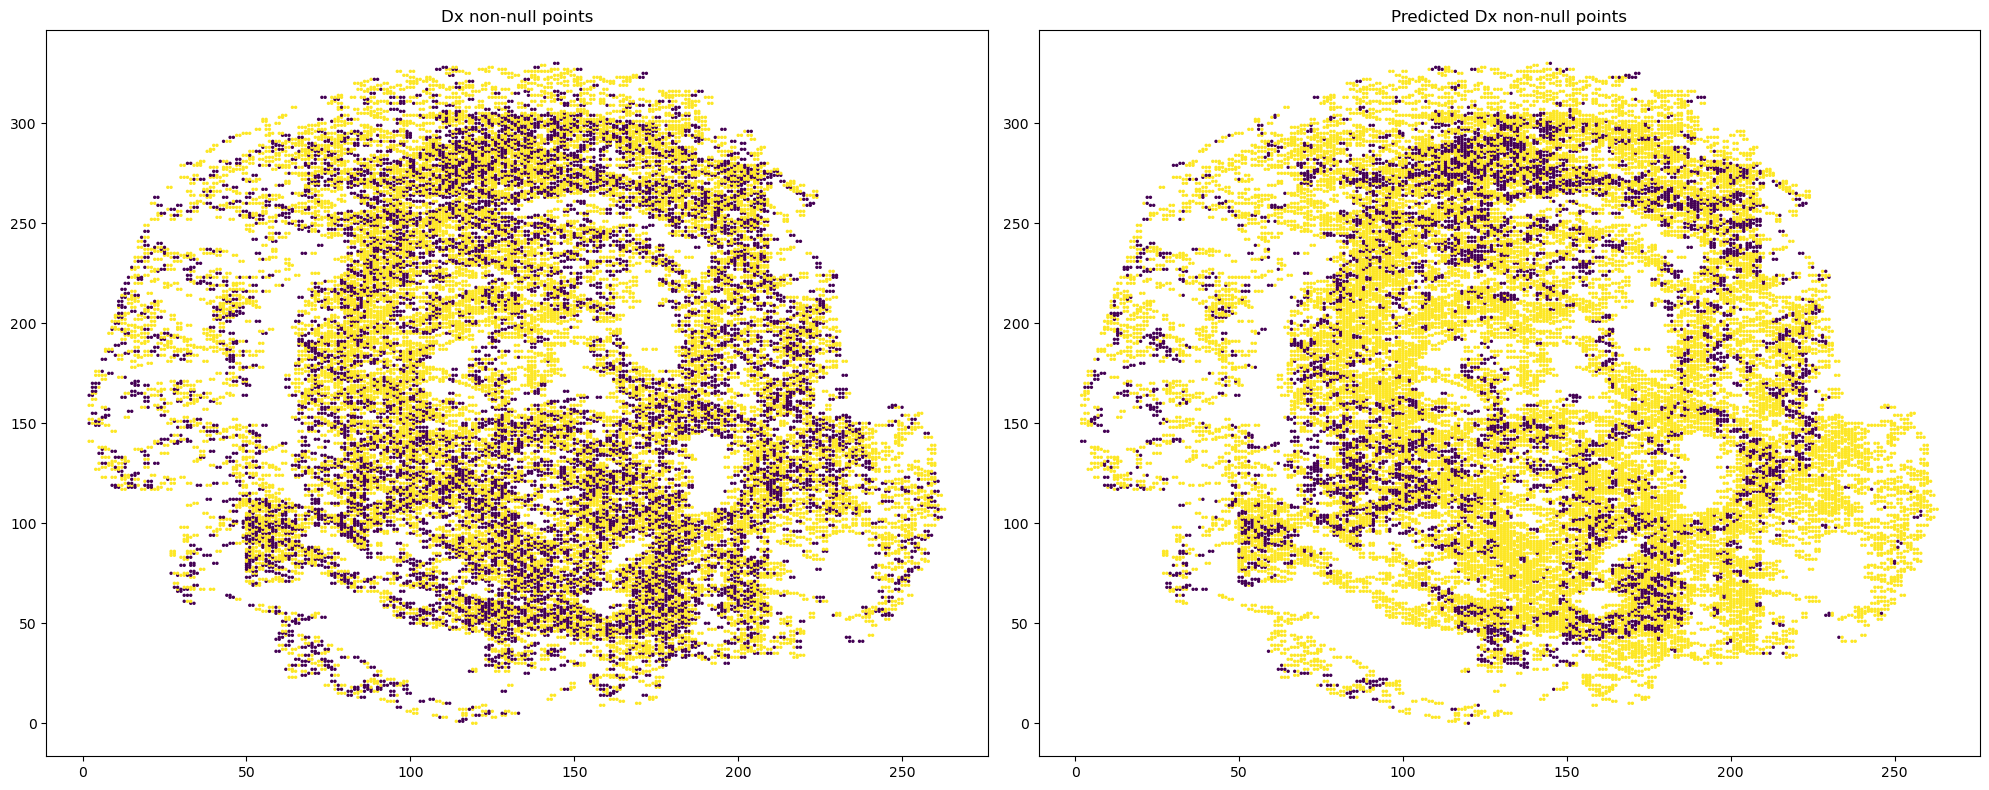

In [46]:
# a plot to show the discretization result. For best visualization, the cell_size is large.

fig, axs = plt.subplots(figsize=(20, 8), nrows = 1, ncols = 2)

xx, yy = np.where(~np.isnan(Dx[:, :, 0]))
axs[0].scatter(xx, yy, s=2, c=(Dx[xx, yy, 0] < 0.01))
axs[0].title.set_text('Dx non-null points')
xx, yy = np.where(~np.isnan(Dx[:, :, 0]))
axs[1].scatter(xx, yy, s=2, c=(Dx_pred[xx, yy, 0] < 0.01))
axs[1].title.set_text('Predicted Dx non-null points')

# purple ~ 0, yellow ~ 1.
plt.tight_layout()
plt.show()

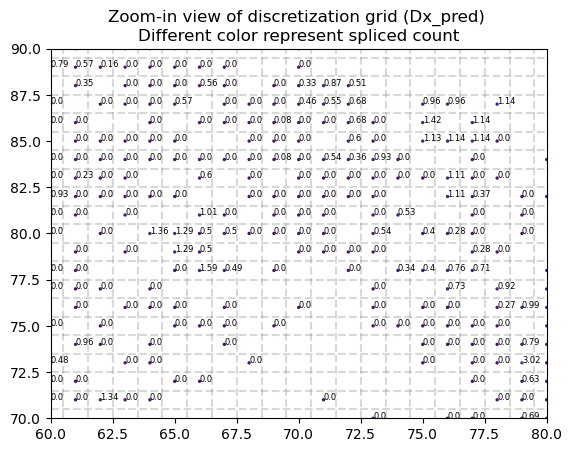

In [31]:
xx, yy = np.where(~np.isnan(S[:, :, 0]))
plt.scatter(xx, yy, s=2, c=Dx_pred[xx, yy, 0])

for y in np.linspace(70.5, 89.5, 20):
    plt.axhline(y, linestyle='--', alpha=0.3, color='grey')
for x in np.linspace(60.5, 79.5, 20):
    plt.axvline(x, linestyle='--', alpha=0.3, color='grey')

for ix, iy in zip(xx, yy):
    if ix not in np.arange(60, 80) or iy not in np.arange(70, 90):
        continue
    plt.annotate(round(Dx_pred[ix, iy, 0], 2), (ix, iy), fontsize=6)

plt.xlim(60, 80)
plt.ylim(70, 90)
plt.title('Zoom-in view of discretization grid (Dx_pred) \nDifferent color represent spliced count')
plt.show()

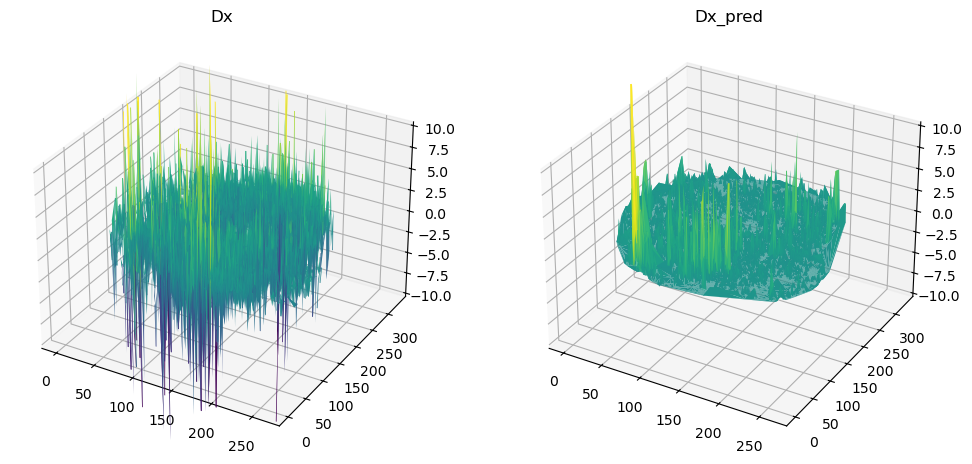

In [32]:
# plot the distribution of S, Dx, Dy
from mpl_toolkits.mplot3d.axes3d import Axes3D

gene = 0

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_trisurf(xx, yy, Dx[xx, yy, gene], cmap='viridis', vmin=-10, vmax=10)
ax1.set_zlim(-10, 10)
ax1.set_title('Dx')

ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_trisurf(xx, yy, Dx_pred[xx, yy, gene], cmap='viridis', vmin=-10, vmax=10)
ax2.set_zlim(-10, 10)
ax2.set_title('Dx_pred')

plt.show()

In [33]:
from scipy.stats import pearsonr, spearmanr
pearsonr(Dx_cell_pred[xgrad_notNaN][:, 0].squeeze().detach().numpy(), Dx_cell[xgrad_notNaN][:, 0])

PearsonRResult(statistic=0.02392666000069095, pvalue=5.887056960939169e-07)

In [34]:
spearmanr(Dx_cell_pred[xgrad_notNaN][:, 0].squeeze().detach().numpy(), Dx_cell[xgrad_notNaN][:, 0])

SignificanceResult(statistic=0.02257315045429757, pvalue=2.449899206339959e-06)